<a href="https://colab.research.google.com/github/jrzkaminski/IndustrialML-ITMO/blob/main/Regressors_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs, data importing

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from rich.progress import track
from datetime import date
from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
import holidays
warnings.filterwarnings('ignore')



In [ ]:
data_train = pd.read_csv('data/train_preprocessed.csv')
data_train.drop('Unnamed: 0', axis=1, inplace=True)
lat_center, lon_center = data_train.lat.mean(), data_train.lon.mean()
data_train['lon_center'] = data_train['lon'] - lon_center
data_train['lat_center'] = data_train['lat'] - lat_center
data_train_big = data_train[data_train.num_posts > 2]

In [ ]:
data_test = pd.read_csv('data/test.csv')
gs = gpd.GeoSeries.from_wkb(data_test['point'])
geo_test = gpd.GeoDataFrame(data_test, geometry=gs,crs='EPSG:4326').to_crs('EPSG:5940')

data_test['lon'] = gs.centroid.x
data_test['lat'] = gs.centroid.y
data_test['lon_center'] = data_test['lon'] - lon_center
data_test['lat_center'] = data_test['lat'] - lat_center
data_test

,hour,lat,lon,point,sum,error,geometry,lon_center,lat_center
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,POINT (30.33162 59.93486),0.003736,-0.000376
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,POINT (30.32937 59.94049),0.001490,0.005249
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,POINT (30.29793 59.90560),-0.029951,-0.029642
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,POINT (30.35632 59.92136),0.028440,-0.013880
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,POINT (30.31590 59.93936),-0.011984,0.004124
...,...,...,...,...,...,...,...,...,...
695,1582059600,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,POINT (30.33162 59.92699),0.003736,-0.008253
696,1582038000,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,POINT (30.29568 59.92586),-0.032196,-0.009378
697,1581926400,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,POINT (30.28221 59.93711),-0.045671,0.001874
698,1582099200,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,POINT (30.32263 59.93374),-0.005247,-0.001501


In [ ]:
data_val = pd.read_csv('data/valid.csv')
# drop row 0101000020E610000000000000000000000000000000000000
data_val = data_val[data_val['point'] != '0101000020E610000000000000000000000000000000000000']
gs = gpd.GeoSeries.from_wkb(data_val['point'])
geo_test = gpd.GeoDataFrame(data_val, geometry=gs,crs='EPSG:4326').to_crs('EPSG:5940')
data_val['lon'] = gs.centroid.x
data_val['lat'] = gs.centroid.y
data_val['lon_center'] = data_val['lon'] - lon_center
data_val['lat_center'] = data_val['lat'] - lat_center
data_val

,hour,lat,lon,point,sum,error,geometry,lon_center,lat_center
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402,POINT (30.31814 59.92699),-0.009739,-0.008253
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291,POINT (30.24178 59.92474),-0.086095,-0.010504
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735,POINT (30.29568 60.00230),-0.032196,0.067061
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735,POINT (30.32488 59.93599),-0.003001,0.000749
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735,POINT (30.30691 59.93374),-0.020967,-0.001501
...,...,...,...,...,...,...,...,...,...
704,1580659200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735,POINT (30.29793 59.90560),-0.029951,-0.029642
705,1581048000,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735,POINT (30.31590 59.95061),-0.011984,0.015371
706,1581656400,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735,POINT (30.30916 59.93374),-0.018722,-0.001501
707,1580724000,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402,POINT (30.35857 59.93149),0.030686,-0.003752


# Split data into year, month, day, hour and adding holidays, weekends, weekdays

Add datetime column to test and valid datasets

In [ ]:
data_test['datetime'] = pd.to_datetime(data_test['hour'], unit='s')
data_val['datetime'] = pd.to_datetime(data_val['hour'], unit='s')
data_train['datetime'] = pd.to_datetime(data_train['time'])

In [ ]:
data_train

,point,lon,lat,time,timestamp,num_posts,lon_center,lat_center,datetime
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 11:00:00,1574420400,1,-0.211859,-0.099533,2019-11-22 11:00:00
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 12:00:00,1574424000,1,-0.211859,-0.099533,2019-11-22 12:00:00
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-23 13:00:00,1574514000,1,-0.211859,-0.099533,2019-11-23 13:00:00
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-25 16:00:00,1574697600,1,-0.211859,-0.099533,2019-11-25 16:00:00
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-27 10:00:00,1574848800,1,-0.211859,-0.099533,2019-11-27 10:00:00
...,...,...,...,...,...,...,...,...,...
3625651,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-06 04:00:00,3151209600,2,0.194628,-0.036399,2019-12-06 04:00:00
3625652,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-23 08:00:00,1577088000,1,0.194628,-0.036399,2019-12-23 08:00:00
3625653,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-06-10 09:00:00,1560157200,1,0.194628,-0.064569,2019-06-10 09:00:00
3625654,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-10-06 14:00:00,1570370400,1,0.194628,-0.064569,2019-10-06 14:00:00


Add yyyy, mm, dd, hh to test and valid

In [ ]:
data_train["dayhour"] = data_train["datetime"].dt.hour
data_train["weekday"] = data_train["datetime"].dt.weekday

data_test["dayhour"] = data_test["datetime"].dt.hour
data_test["weekday"] = data_test["datetime"].dt.weekday

data_val["dayhour"] = data_val["datetime"].dt.hour
data_val["weekday"] = data_val["datetime"].dt.weekday

Add holidays

In [ ]:
holidays_russia = holidays.country_holidays('RU', years = [2019, 2020])

data_train['is_holiday'] = data_train['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_test['is_holiday'] = data_test['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_val['is_holiday'] = data_val['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)

In [ ]:
data_train = data_train.drop(['time'], axis=1)

# Regressions: catboost, lightgbm, xgboost and linear

In [ ]:
def custom_metric(y_true, y_pred):
    return abs(y_true - y_pred) / y_pred

def flatten(l):
    return [item for sublist in l for item in sublist]

def learn_regressor(data_train: pd.DataFrame, data_test: pd.DataFrame, model):

    data_test_boost_prediction = []
    data_test_boost_error = []
    test_unique_points = data_test['point'].unique()

    for point in track(test_unique_points, description='Learning'):
        model = model
        data_train_point = data_train[data_train['point'] == point]
        data_test_point = data_test[data_test['point'] == point]

        X_train = data_train_point[['timestamp', 'dayhour', 'weekday', 'is_holiday']]
        y_train = data_train_point['num_posts']

        X_test = data_test_point[['hour', 'dayhour', 'weekday', 'is_holiday']]
        X_test = X_test.rename(columns={'hour': 'timestamp'})
        y_test = data_test_point['sum']

        model.fit(X_train, y_train)
        y_pred = np.round(model.predict(X_test))
        data_test_boost_prediction.append(y_pred)
        data_test_boost_error.append(custom_metric(np.array(y_test), np.array(y_pred)))

    return data_test_boost_error, data_test_boost_prediction


## XGBoost

In [ ]:
data_train_big = data_train[data_train.num_posts > 2]
X_train = data_train_big[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_train = data_train_big['num_posts']
data_val = data_val.rename(columns={'hour': 'timestamp'})
data_test = data_test.rename(columns={'hour': 'timestamp'})

X_val = data_val[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_val = data_val['sum']

X_test = data_test[['lon_center', 'lat_center', 'dayhour', 'weekday', 'is_holiday']]
y_test = data_test['sum']



In [ ]:
X_train

,lon_center,lat_center,dayhour,weekday,is_holiday
118,-0.079358,0.035607,17,6,0
126,-0.079358,0.035607,11,0,0
130,-0.079358,0.035607,16,0,0
143,-0.079358,0.035607,16,1,0
151,-0.079358,0.035607,17,2,0
...,...,...,...,...,...
3625102,0.194628,-0.037526,9,0,0
3625192,0.194628,-0.037526,20,0,0
3625221,0.194628,-0.037526,18,3,0
3625412,0.194628,0.045721,16,1,0


In [ ]:
%%time

model_xgb = XGBRFRegressor(
    n_estimators=100, 
    objective='reg:squarederror', 
    seed=42, 
    # gamma=5, 
    # booster = "gblinear"
    )

model_xgb.fit(X_train, y_train)

CPU times: user 32.4 s, sys: 234 ms, total: 32.7 s
Wall time: 7.33 s


XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', max_bin=256, max_cat_threshold=64,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=42,
               reg_alpha=0, ...)

In [ ]:
xgb_pred_val = np.round(model_xgb.predict(X_val))
data_val_xgb_prediction = []
data_val_xgb_error = []
data_val_xgb_prediction.append(xgb_pred_val)
data_val_xgb_error.append(custom_metric(np.array(y_val), np.array(xgb_pred_val)))
print('Val set')
print(f'regression metric {np.array(data_val_xgb_error).mean()}')

xgb_pred_test = np.round(model_xgb.predict(X_test))
data_test_xgb_prediction = []
data_test_xgb_error = []
data_test_xgb_prediction.append(xgb_pred_test)
data_test_xgb_error.append(custom_metric(np.array(y_test), np.array(xgb_pred_test)))
print('Test set')
print(f'regression metric {np.array(data_test_xgb_error).mean()}')

Val set
regression metric 0.5820605779060589
Test set
regression metric 0.5760693433550577


## CatBoost 

In [ ]:
model_catboost = CatBoostRegressor(iterations=200, silent=True, random_seed=42).fit(X_train, y_train) 


In [ ]:
cb_pred_val = np.round(model_catboost.predict(X_val))
data_val_cb_prediction = []
data_val_cb_error = []
data_val_cb_prediction.append(cb_pred_val)
data_val_cb_error.append(custom_metric(np.array(y_val), np.array(cb_pred_val)))
print('Val set')
print(f'regression metric {np.array(data_val_cb_error).mean()}')

cb_pred_test = np.round(model_catboost.predict(X_test))
data_test_cb_prediction = []
data_test_cb_error = []
data_test_cb_prediction.append(cb_pred_test)
data_test_cb_error.append(custom_metric(np.array(y_test), np.array(cb_pred_test)))
print('Test set')
print(f'regression metric {np.array(data_test_cb_error).mean()}')

Val set
regression metric 0.5407239944073429
Test set
regression metric 0.5312711420489677


## LightGBM

In [ ]:
%%time

model_lgbm = LGBMRegressor(random_seed=42).fit(X_train, y_train) 

CPU times: user 7.77 s, sys: 84.3 ms, total: 7.85 s
Wall time: 1.08 s


In [ ]:
lgbm_pred_val = np.round(model_lgbm.predict(X_val))
data_val_lgbm_prediction = []
data_val_lgbm_error = []
data_val_lgbm_prediction.append(lgbm_pred_val)
data_val_lgbm_error.append(custom_metric(np.array(y_val), np.array(lgbm_pred_val)))
print('Val set')
print(f'regression metric {np.array(data_val_lgbm_error).mean()}')

lgbm_pred_val = np.round(model_lgbm.predict(X_test))
data_test_lgbm_prediction = []
data_test_lgbm_error = []
data_test_lgbm_prediction.append(lgbm_pred_val)
data_test_lgbm_error.append(custom_metric(np.array(y_test), np.array(lgbm_pred_val)))
print('Test set')
print(f'regression metric {np.array(data_test_lgbm_error).mean()}')

Val set
regression metric 0.5496903204958608
Test set
regression metric 0.5441220156471372


## Linear Regression

In [ ]:
model_linear = LinearRegression().fit(X_train, y_train) 

In [ ]:
linear_pred_val = np.round(model_linear.predict(X_val))
data_val_linear_prediction = []
data_val_linear_prediction.append(linear_pred_val)
data_val_linear_error = []
data_val_linear_error.append(custom_metric(np.array(y_val), np.array(linear_pred_val)))
print('Val set')
print(f'regression metric {np.array(data_val_linear_error).mean()}')

linear_pred_test = np.round(model_linear.predict(X_test))
data_test_linear_prediction = []
data_test_linear_error = []
data_test_linear_prediction.append(linear_pred_test)
data_test_linear_error.append(custom_metric(np.array(y_test), np.array(linear_pred_test)))
print('Test set')
print(f'regression metric {np.array(data_test_linear_error).mean()}')

Val set
regression metric 0.6805295247350641
Test set
regression metric 0.6987477324263038


## AutoML

In [14]:
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline

def metrics(y_true: np.array, y_pred: np.array) -> np.array:
  return np.mean(np.abs(y_true - y_pred) / y_pred)

def get_pipeline():
  return Pipeline(PrimaryNode('lgbmreg'))


In [ ]:
%%time

from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum

task = 'regression'
fit_data = InputData(idx=np.arange(0, len(X_train)),
                            features=X_train.values,
                            target=y_train.values,
                            task=task,
                            data_type=DataTypesEnum.table)

test_data = InputData(idx=np.arange(0, len(X_test)),
                            features=X_test.values,
                            target=y_test.values,
                            task=task,
                            data_type=DataTypesEnum.table)

val_data = InputData(idx=np.arange(0, len(X_val)),
                            features=X_val.values,
                            target=y_val.values,
                            task=task,
                            data_type=DataTypesEnum.table)

automl_model = Fedot(problem=task, timeout=120,
                     safe_mode=False,
                     metric='mae',
                     preset='best_quality',
                     initial_assumption=get_pipeline())

automl_model.fit(features=fit_data,
                 target=fit_data.target)

prediction_test = np.ravel(automl_model.predict(test_data))
print(f'Metric for test dataset is {metrics(y_test, np.round(prediction_test))}')

prediction_val = np.ravel(automl_model.predict(val_data))
print(f'Metric for val dataset is {metrics(y_val, np.round(prediction_val))}')

CRITICAL:root:ApiComposer - Initial pipeline was fitted in 14.2 sec.


2022-11-16 19:00:19,188 - ApiComposer - Initial pipeline was fitted in 14.2 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: True Time limit: 120 min Set of candidate models: ['dtreg', 'poly_features', 'ransac_non_lin_reg', 'pca', 'normalization', 'adareg', 'scaling', 'svr', 'treg', 'sgdr', 'isolation_forest_reg', 'lasso', 'knnreg', 'ransac_lin_reg', 'linear', 'fast_ica', 'rfr', 'gbr', 'lgbmreg', 'ridge']


2022-11-16 19:00:19,203 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 120 min Set of candidate models: ['dtreg', 'poly_features', 'ransac_non_lin_reg', 'pca', 'normalization', 'adareg', 'scaling', 'svr', 'treg', 'sgdr', 'isolation_forest_reg', 'lasso', 'knnreg', 'ransac_lin_reg', 'linear', 'fast_ica', 'rfr', 'gbr', 'lgbmreg', 'ridge']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-16 19:00:19,330 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2022-11-16 20:21:50,718 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [1:21:29<?, ?gen/s]
CRITICAL:root:ApiComposer - Hyperparameters tuning started with 38 min. timeout


2022-11-16 20:21:50,743 - ApiComposer - Hyperparameters tuning started with 38 min. timeout
  0%|          | 18/100000 [40:29<3748:57:31, 134.99s/trial, best loss: 2.5477165797040096]


CRITICAL:root:ApiComposer - Hyperparameters tuning finished


2022-11-16 21:07:11,274 - ApiComposer - Hyperparameters tuning finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-16 21:07:11,540 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-16 21:07:21,658 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [lgbmreg]}


2022-11-16 21:07:21,672 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [lgbmreg]}
Metric for test dataset is 0.5187069649305421
Metric for val dataset is 0.5177100722074355
CPU times: user 2h 33min 57s, sys: 1min 26s, total: 2h 35min 24s
Wall time: 2h 7min 39s


In [ ]:
prediction_test = np.ravel(automl_model.predict(test_data))
print(f'Metric for test dataset is {metrics(y_test, np.round(prediction_test))}')

prediction_val = np.ravel(automl_model.predict(val_data))
print(f'Metric for val dataset is {metrics(y_val, np.round(prediction_val))}')

Metric for test dataset is 0.5187069649305421
Metric for val dataset is 0.5177100722074355


In [62]:
automl_model.current_pipeline.print_structure()

Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [lgbmreg]}
lgbmreg - {'num_leaves': 250, 'colsample_bytree': 0.9229854211753922, 'subsample': 0.9058860406976823, 'subsample_freq': 10, 'learning_rate': 0.11655185170185552, 'n_estimators': 100, 'reg_alpha': 0.8120688195187689, 'reg_lambda': 0.018509506906623164}


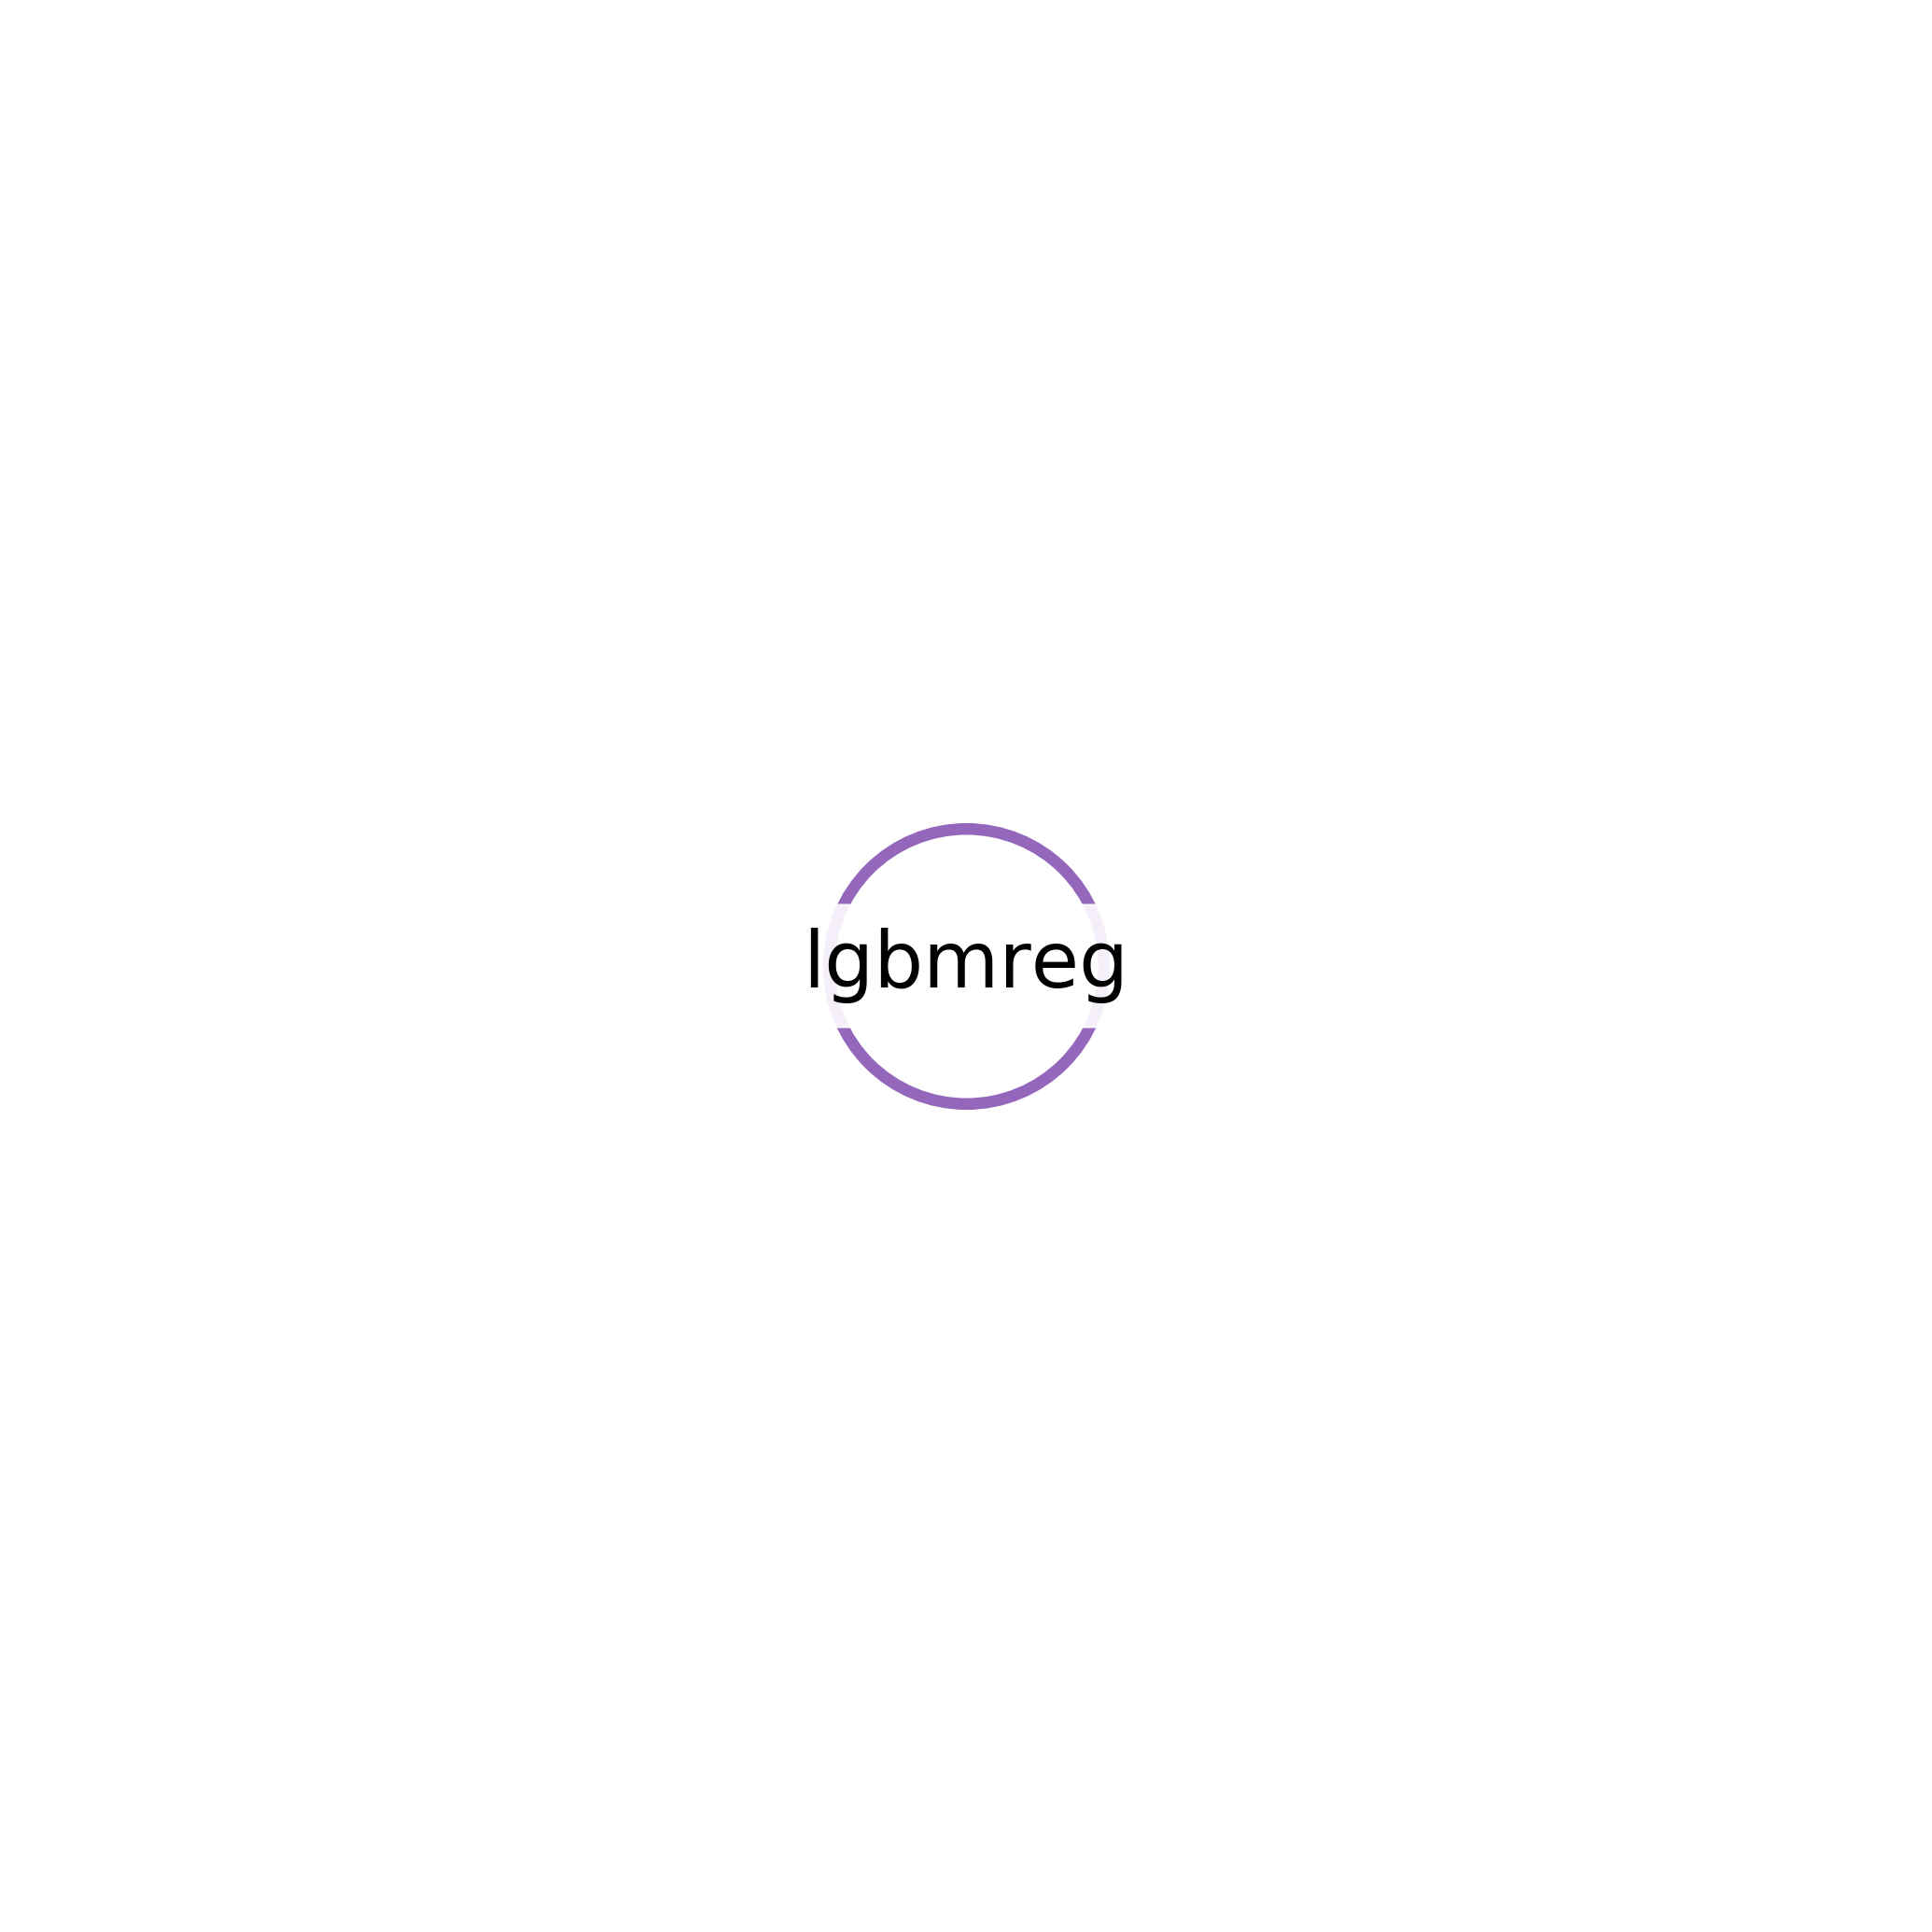

In [ ]:
automl_model.current_pipeline.show()

## Visualization

### Regressors

#### Unpopular cube

In [ ]:
unpopular_point = data_val.point.unique()[2]
popular_point = data_val.point.unique()[39]

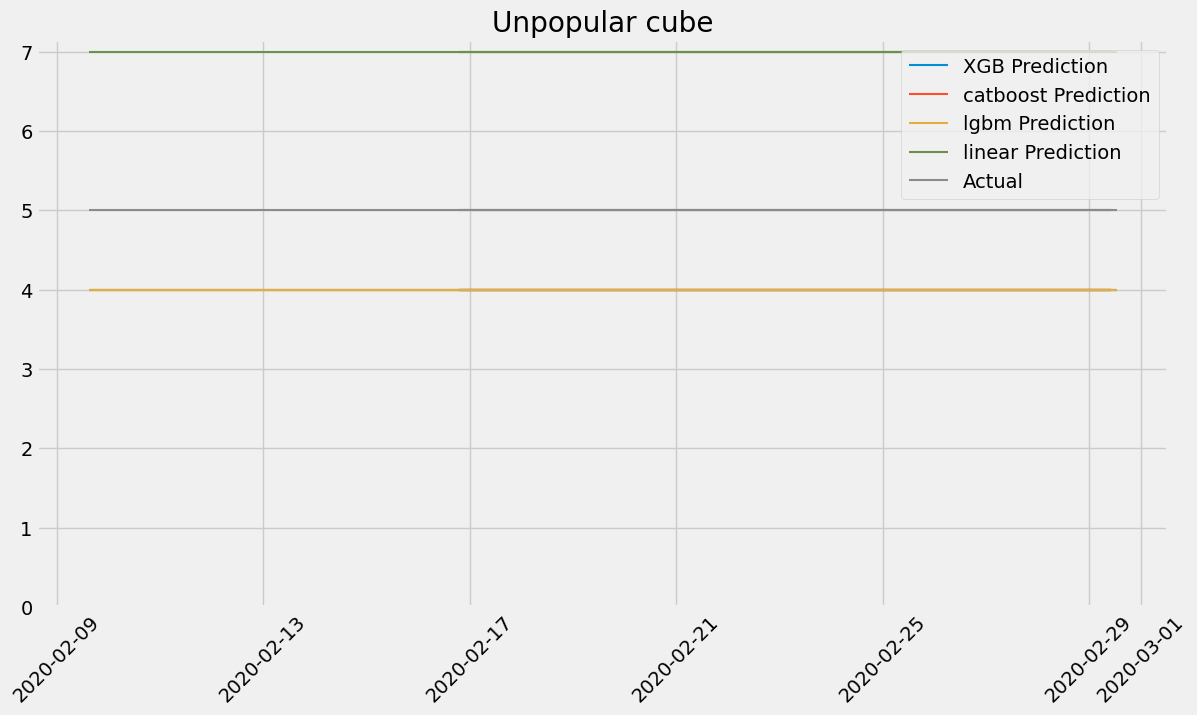

In [ ]:
X_val_plot = data_val[data_val['point'] == unpopular_point][['lon_center', 'datetime', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_val_plot = data_val[data_val['point'] == unpopular_point][['datetime', 'sum']]
y_val_plot


xgb_pred_val_plot = np.round(model_xgb.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
catboost_pred_val_plot = np.round(model_catboost.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
lgbm_pred_val_plot = np.round(model_lgbm.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
linear_pred_val_plot = np.round(model_linear.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
# data_val_xgb_prediction = []
# data_val_xgb_error = []
# data_val_xgb_prediction.append(xgb_pred_val_plot)

# data_val_xgb_error.append(custom_metric(np.array(y_val_plot['sum']), np.array(xgb_pred_val_plot)))

y_val_plot['xgb_prediction'] = xgb_pred_val_plot
y_val_plot['catboost_prediction'] = catboost_pred_val_plot
y_val_plot['lgbm_prediction'] = lgbm_pred_val_plot
y_val_plot['linear_prediction'] = linear_pred_val_plot

plt.figure(figsize=(13, 7))
plt.grid()
plt.plot(y_val_plot['datetime'], y_val_plot['xgb_prediction'], label='XGB Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['catboost_prediction'], label='catboost Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['lgbm_prediction'], label='lgbm Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['linear_prediction'], label='linear Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['sum'], label='Actual', clip_on=False,)

plt.grid()
plt.legend(loc='upper right')
plt.title(f'Unpopular cube') # , metric = {np.array(data_val_xgb_error).mean():.3f}
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()

#### Popular cube

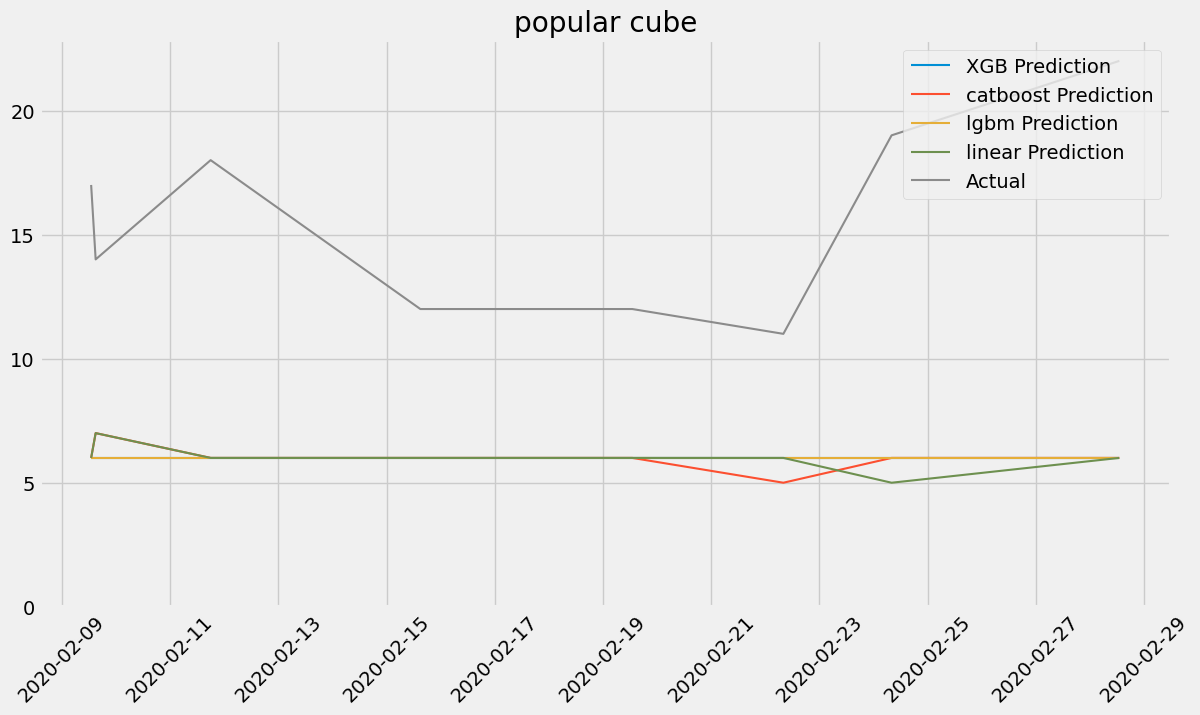

In [ ]:
X_val_plot = data_val[data_val['point'] == popular_point][['lon_center', 'datetime', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_val_plot = data_val[data_val['point'] == popular_point][['datetime', 'sum']]
y_val_plot


xgb_pred_val_plot = np.round(model_xgb.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
catboost_pred_val_plot = np.round(model_catboost.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
lgbm_pred_val_plot = np.round(model_lgbm.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
linear_pred_val_plot = np.round(model_linear.predict(X_val_plot[['lon_center', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]))
# data_val_xgb_prediction = []
# data_val_xgb_error = []
# data_val_xgb_prediction.append(xgb_pred_val_plot)

# data_val_xgb_error.append(custom_metric(np.array(y_val_plot['sum']), np.array(xgb_pred_val_plot)))

y_val_plot['xgb_prediction'] = xgb_pred_val_plot
y_val_plot['catboost_prediction'] = catboost_pred_val_plot
y_val_plot['lgbm_prediction'] = lgbm_pred_val_plot
y_val_plot['linear_prediction'] = linear_pred_val_plot
y_val_plot = y_val_plot.sort_values(by='datetime')
plt.figure(figsize=(13, 7))
plt.grid()
plt.plot(y_val_plot['datetime'], y_val_plot['xgb_prediction'], label='XGB Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['catboost_prediction'], label='catboost Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['lgbm_prediction'], label='lgbm Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['linear_prediction'], label='linear Prediction', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['sum'], label='Actual', clip_on=False,)

plt.grid()
plt.legend(loc='upper right')
plt.title(f'popular cube') # , metric = {np.array(data_val_xgb_error).mean():.3f}
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()

#### Error plots

In [ ]:
X_val_plot = data_val[['lon_center', 'datetime', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_val_plot = data_val[['datetime', 'sum']]
y_val_plot

,datetime,sum
0,2020-02-23 09:00:00,5
1,2020-02-20 19:00:00,14
2,2020-02-09 15:00:00,5
3,2020-02-17 17:00:00,7
4,2020-02-27 05:00:00,14
...,...,...
704,2020-02-02 16:00:00,7
705,2020-02-07 04:00:00,8
706,2020-02-14 05:00:00,6
707,2020-02-03 10:00:00,8


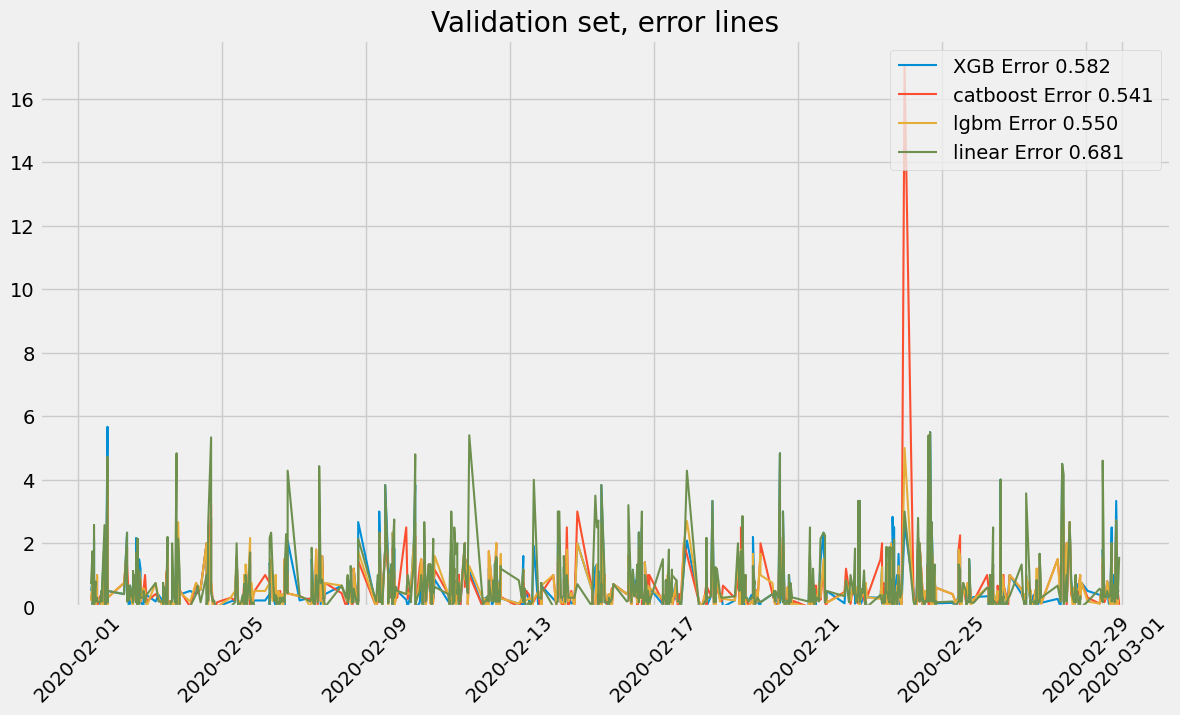

In [ ]:
y_val_plot['xgb_error'] = data_val_xgb_error[0]
y_val_plot['cb_error'] = data_val_cb_error[0]
y_val_plot['lgbm_error'] = data_val_lgbm_error[0]
y_val_plot['linear_error'] = data_val_linear_error[0]
y_val_plot = y_val_plot.sort_values(by='datetime')

plt.figure(figsize=(13, 7))
plt.grid()
plt.plot(y_val_plot['datetime'], y_val_plot['xgb_error'], label=f'XGB Error {np.array(data_val_xgb_error).mean():0.3f}', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['cb_error'], label=f'catboost Error {np.array(data_val_cb_error).mean():0.3f}', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['lgbm_error'], label=f'lgbm Error {np.array(data_val_lgbm_error).mean():0.3f}', clip_on=False,)
plt.plot(y_val_plot['datetime'], y_val_plot['linear_error'], label=f'linear Error {np.array(data_val_linear_error).mean():0.3f}', clip_on=False,)

plt.grid()
plt.legend(loc='upper right')
plt.title(f'Validation set, error lines') # , metric = {np.array(data_val_xgb_error).mean():.3f}
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()


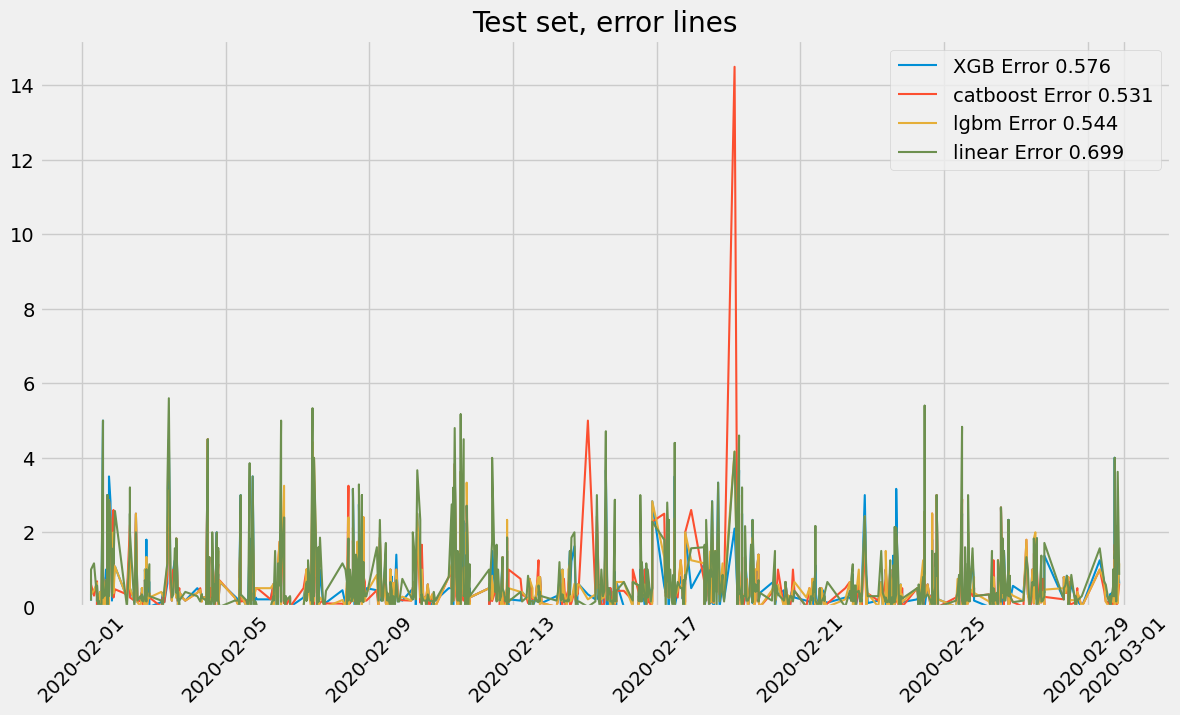

In [ ]:
X_test_plot = data_test[['lon_center', 'datetime', 'lat_center',  'dayhour', 'weekday', 'is_holiday']]
y_test_plot = data_test[['datetime', 'sum']]
y_test_plot

y_test_plot['xgb_error'] = data_test_xgb_error[0]
y_test_plot['cb_error'] = data_test_cb_error[0]
y_test_plot['lgbm_error'] = data_test_lgbm_error[0]
y_test_plot['linear_error'] = data_test_linear_error[0]
y_test_plot = y_test_plot.sort_values(by='datetime')

plt.figure(figsize=(13, 7))
plt.grid()
plt.plot(y_test_plot['datetime'], y_test_plot['xgb_error'], label=f'XGB Error {np.array(data_test_xgb_error).mean():0.3f}', clip_on=False,)
plt.plot(y_test_plot['datetime'], y_test_plot['cb_error'], label=f'catboost Error {np.array(data_test_cb_error).mean():0.3f}', clip_on=False,)
plt.plot(y_test_plot['datetime'], y_test_plot['lgbm_error'], label=f'lgbm Error {np.array(data_test_lgbm_error).mean():0.3f}', clip_on=False,)
plt.plot(y_test_plot['datetime'], y_test_plot['linear_error'], label=f'linear Error {np.array(data_test_linear_error).mean():0.3f}', clip_on=False,)

plt.grid()
plt.legend(loc='upper right')
plt.title(f'Test set, error lines') # , metric = {np.array(data_val_xgb_error).mean():.3f}
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()

### AutoML

#### Unpopular point

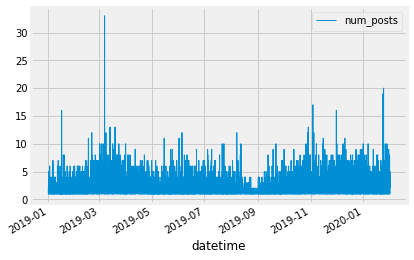

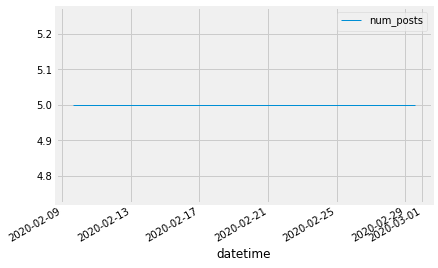

In [42]:
df_train = data_train[data_train['point'] == unpopular_point][['num_posts', 'datetime']]
df_train.plot('datetime', 'num_posts')
df_val = data_val[data_val['point'] == unpopular_point][['num_posts', 'automl_prediction', 'datetime']]
df_val.plot('datetime', 'num_posts')

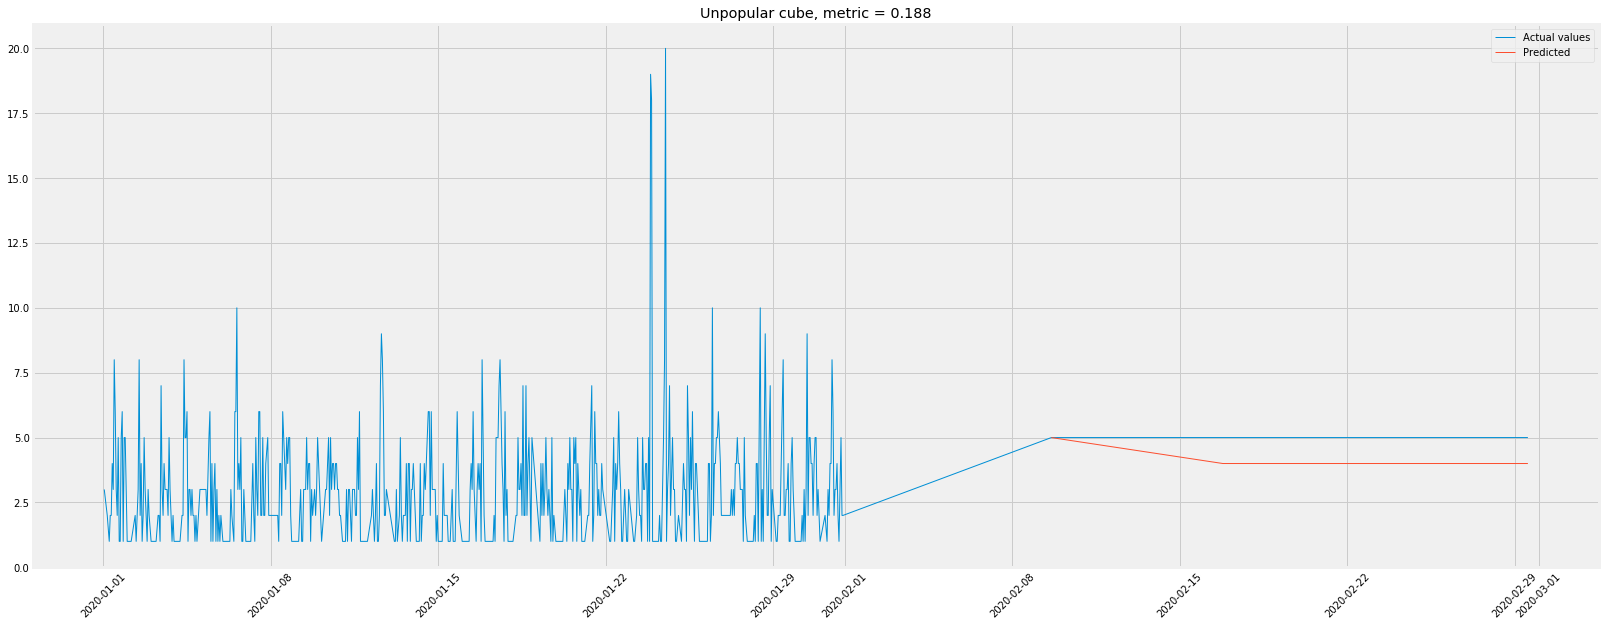

In [43]:
val_plot_data = df_val[['datetime', 'automl_prediction']].sort_values(by='datetime').set_index('datetime')
train_plot = pd.concat([df_train[df_train['datetime'] > '2020-01-01'], df_val[['datetime', 'num_posts']].sort_values(by='datetime')]).set_index('datetime')
metric = metrics(df_val['num_posts'], df_val['automl_prediction'])

plt.figure(figsize=(25,10))
plt.grid()
plt.plot(train_plot, label='Actual values')
plt.plot(val_plot_data, label='Predicted')
plt.grid()
plt.legend(loc='Left corner')
plt.title(f'Unpopular cube, metric = {np.round(metric, 3)}')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()

#### Popular point

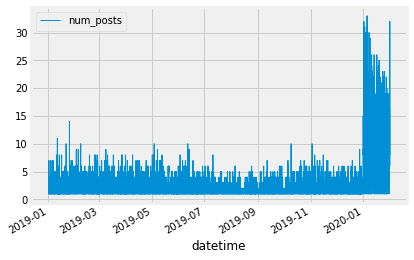

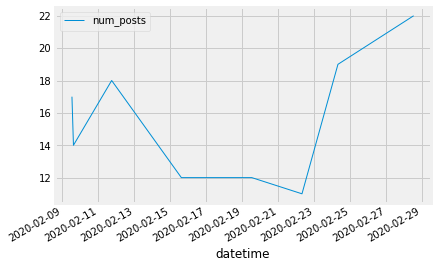

In [44]:
df_train = data_train[data_train['point'] == popular_point][['num_posts', 'datetime']]
df_train.plot('datetime', 'num_posts')
df_val = data_val[data_val['point'] == popular_point][['num_posts', 'automl_prediction', 'datetime']]
df_val.plot('datetime', 'num_posts')

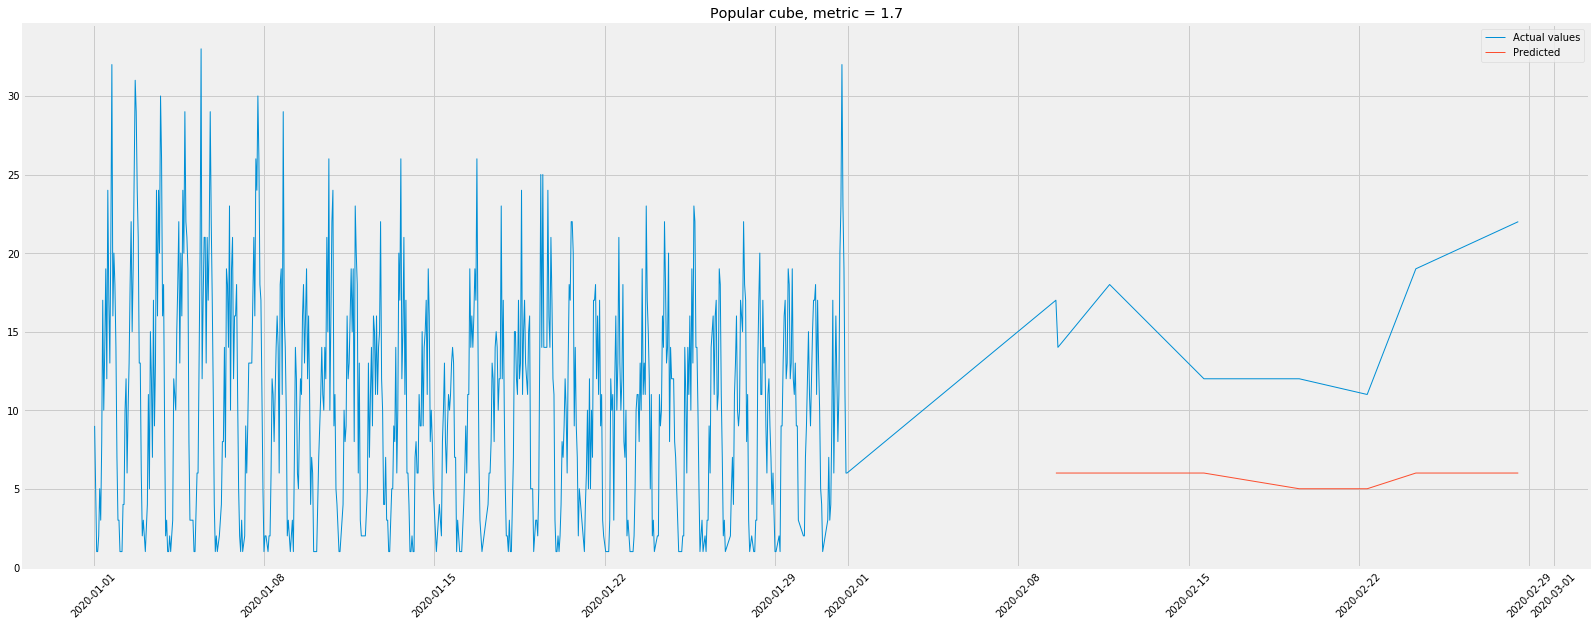

In [45]:
val_plot_data = df_val[['datetime', 'automl_prediction']].sort_values(by='datetime').set_index('datetime')
train_plot = pd.concat([df_train[df_train['datetime'] > '2020-01-01'], df_val[['datetime', 'num_posts']].sort_values(by='datetime')]).set_index('datetime')
metric = metrics(df_val['num_posts'], df_val['automl_prediction'])

plt.figure(figsize=(25,10))
plt.grid()
plt.plot(train_plot, label='Actual values')
plt.plot(val_plot_data, label='Predicted')
plt.grid()
plt.legend(loc='Left corner')
plt.title(f'Popular cube, metric = {np.round(metric, 3)}')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()